In [195]:
import gensim.downloader as api

import pandas as pd
import re
import pickle
import numpy as np
from time import time
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import MiniBatchKMeans
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score

from wordcloud import WordCloud

Importing ingredients

In [30]:
def import_data():
    '''Import cleaned recipe, raw recipe and ratings data'''
    #cleaned recipes
    recipes = pd.read_csv('PP_recipes.csv')
    del recipes['i']
    del recipes['name_tokens']
    del recipes['ingredient_tokens']
    del recipes['steps_tokens']
    recipes = recipes.set_index('id')

    #ratings
    ratings = pd.read_csv('RAW_interactions.csv')
    del ratings['user_id']
    del ratings['date']
    del ratings['review']
    ratings = ratings.set_index('recipe_id')

    #raw recipe info
    raw_recipes = pd.read_csv('RAW_recipes.csv')
    del raw_recipes['contributor_id']
    del raw_recipes['submitted']
    del raw_recipes['tags']
    del raw_recipes['steps']
    del raw_recipes['description']
    raw_recipes = raw_recipes.set_index('id')

    return (recipes, raw_recipes, ratings)

In [31]:
recipes_, raw_recipes_, ratings_ = import_data()

Encoding one recipe

In [37]:
glove_model = api.load('glove-wiki-gigaword-50')

[==================================================] 100.0% 66.0/66.0MB downloaded


In [63]:
def clean_one_recipe(raw_ingredient_list):
    '''Separate recipe list into individual words'''
    ingredient_list = re.findall('\w+', raw_ingredient_list)
    return ingredient_list

In [170]:
def embed_one_recipe(ingredient_list):
    '''Encode a single recipe'''
    recipe_embedding = []
    for ingredient in ingredient_list:
        try:
            recipe_embedding.append(glove_model[ingredient])
        except:
            recipe_embedding.append(np.zeros((50)))
    recipe_embedding = pd.DataFrame(recipe_embedding).mean(axis=0)
    return recipe_embedding

In [172]:
list_in = raw_recipes_['ingredients'].iloc[0]
ingredient_list = clean_one_recipe(list_in)
recipe_embedding = embed_one_recipe(ingredient_list)
recipe_embedding.head()

0   -0.322388
1    0.215897
2   -0.863623
3    0.342868
4    0.282728
dtype: float32

Encode all recipes

In [137]:
test_range = None

In [138]:
raw_recipes_.shape

(231637, 6)

In [139]:
def timer_func(func):
    '''Wrapper function to time functions'''
    def wrap_func(*args, **kwargs):
        t1 = time()
        result = func(*args, **kwargs)
        t2 = time()
        print(f'Function {func.__name__!r} executed in {(t2-t1):.4f}s')
        return result
    return wrap_func

In [169]:
@timer_func
def encode_recipes():
    '''Encode all recipes'''
    recipe_embeddings = []
    for recipe in raw_recipes_['ingredients'][:test_range]:
        ingredient_list = clean_one_recipe(recipe)
        recipe_embeddings.append(embed_one_recipe(ingredient_list))
    return pd.DataFrame(recipe_embeddings)

In [173]:
encoded_recipes = encode_recipes()

Function 'encode_recipes' executed in 0.0908s


In [174]:
encoded_recipes.shape

(100, 50)

In [175]:
encoded_recipes.head()

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,-0.322388,0.215897,-0.863623,0.342868,0.282728,0.033896,-0.299164,0.145410,-0.023604,0.146014,...,0.273791,0.083687,0.201765,-0.458108,0.748384,0.772295,0.002920,-0.027175,-0.158647,-0.238712
1,0.117049,-0.105789,-0.623373,-0.088335,0.422369,0.864983,-0.313520,0.247731,-0.134833,-0.170577,...,0.644464,0.024751,-0.037983,-0.130208,0.796528,0.849185,-0.199121,-0.088433,-0.238068,0.095297
2,0.031537,-0.195235,-0.472846,0.085179,0.377397,0.272177,-0.133702,-0.080536,-0.099638,-0.011087,...,0.545620,-0.013276,-0.004070,-0.300977,1.176739,0.976502,0.173980,0.092145,0.171500,-0.064618
3,-0.004873,0.243860,-0.687108,0.118598,0.544544,0.371865,-0.158334,-0.048740,-0.333201,-0.064658,...,0.780880,0.144425,0.014742,-0.467413,0.855446,1.010961,-0.023708,-0.193350,-0.302259,-0.083789
4,-0.197585,-0.142786,-0.491921,0.429796,0.255868,0.168091,-0.099953,0.095028,0.164880,0.342105,...,0.634047,-0.039552,-0.113946,-0.497591,0.772490,1.113699,-0.143467,-0.117670,-0.139136,-0.264278


Cluster recipes

In [180]:
@timer_func
def batch_cluster(X_pca,cluster_start=2, cluster_stop=50, cluster_skip=10):    
    '''Clusters data using mini-batch Kmeans'''
    k_range = np.arange(cluster_start,cluster_stop,cluster_skip)
    kmeans = [MiniBatchKMeans(n_clusters = k, n_init=100, random_state=10).fit(X_pca) for k in k_range]
    inertia = [kmeans.inertia_ for kmeans in kmeans]
    labels = [kmeans.labels_ for kmeans in kmeans]
    s_scores = [silhouette_score(X_pca, kmeans_.labels_) for kmeans_ in kmeans]
    return k_range, kmeans, inertia, labels, s_scores

In [199]:
k_range, kmeans, inertia, labels, s_scores = batch_cluster(encoded_recipes, cluster_stop = 21, cluster_skip = 1)

Function 'batch_cluster' executed in 2.3932s


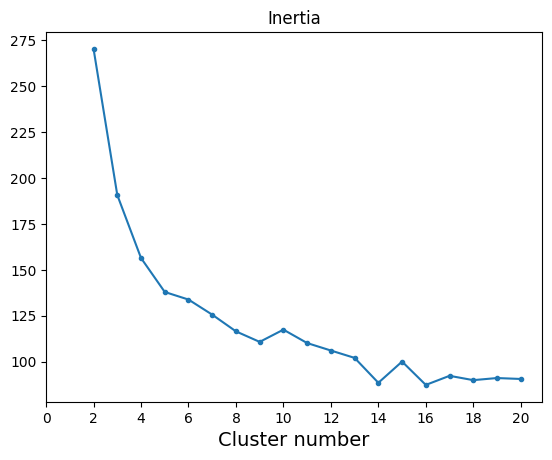

In [200]:
plt.plot(k_range,inertia,'.-')
plt.xlabel('Cluster number', fontsize=14)
#plt.ylabel('Inertia', fontsize=14)
plt.title('Inertia')
plt.xticks(np.arange(0,21,2))
plt.show()

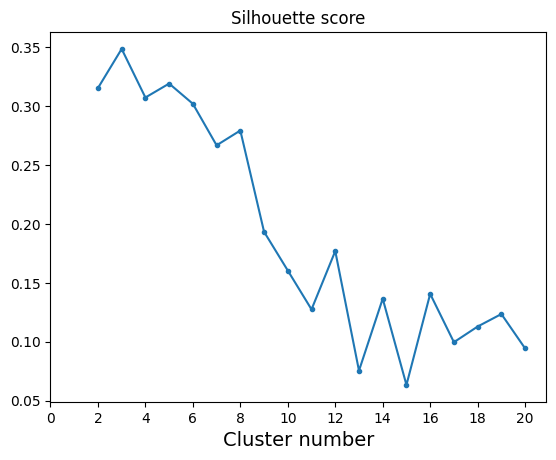

In [201]:
plt.plot(k_range,s_scores,'.-')
plt.xlabel('Cluster number', fontsize=14)
#plt.ylabel('Silhoette score', fontsize=14)
plt.xticks(np.arange(0,21,2))
plt.title('Silhouette score')
plt.show()

In [202]:
#select clusdter number and add cluster ID to embeddings
CLUSTER_NUM = 8
labels_ = labels[CLUSTER_NUM-2]
#encoded_recipes['Cluster ID'] = labels_

T-SNE

In [203]:
encoded_recipes.columns = encoded_recipes.columns.astype(str)
X_embeded = TSNE(n_components=2,n_jobs=-1).fit_transform(encoded_recipes)

In [205]:
Xem = pd.DataFrame(X_embeded,columns=['1','2'])
Xem['Cluster ID'] = labels_
Xem

,1,2,Cluster ID
0,1.537717,-8.607880,0
1,1.364463,-7.789919,5
2,-4.622008,-1.428380,2
3,-4.832150,-2.823169,2
4,-2.195976,-1.182083,2
...,...,...,...
95,-2.042866,3.465632,1
96,0.001736,-5.421650,7
97,1.821392,-7.641569,5
98,-5.463212,4.127227,4


<Axes: xlabel='1', ylabel='2'>

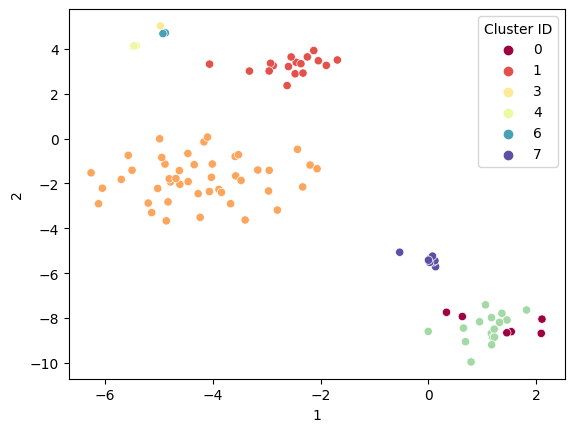

In [206]:
sns.scatterplot(data=Xem, x='1',y='2',hue='Cluster ID',palette='Spectral')

Word clouds

In [207]:
#df_ref['Cluster ID']= labels[0]

count = 1
def show_cloud(embeded_recipes):
    plt.figure(figsize=(6,10))
    for k in range(CLUSTER_NUM):
        df_k = df_ref[df_ref['Cluster ID']==k][key]
        list_k = df_k.to_list()
        cluster_ingred = ''
        for ingredients in list_k:
            list_kk = re.findall(r'(\w[\w\s]+)',ingredients)
            list_kk = filter(filter_common, list_kk)
            cleaned_ingredients = ' '.join(list_kk)
            cluster_ingred += cleaned_ingredients+' '
        wordcloud = WordCloud().generate(cluster_ingred)
        plt.subplot(5,2,k+1)
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title(f'k={k+1}')
    plt.tight_layout()